In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%load_ext autoreload
%autoreload 2

In [2]:
def extract_results(task, fname, end_data_data, is_10k):
    if(is_10K):
        duplicate = 10
    else:
        duplicate = 1
    train_name = (('EDMN-theano/output_data/train_babi%s_metadata_%s.csv' %(task,fname)))
    test_name = (('EDMN-theano/output_data/test_babi%s_metadata_%s.csv' %(task,fname)))
    with open(train_name) as f:
        reader = csv.reader(f)
        i=0
        for l in reader:
            i = i + 1
            if(len(l)==6):
                e = float(l.pop(0))
                if(e<=end_data):# and i%10==0):
                    train_epoch.append(e*10000 + float(l.pop(0)))
                    train_cu_loss.append(l.pop(0))
                    avg_l = float(l.pop(0))
                    train_avg_loss.append(avg_l)
                    train_cu_acc.append(l.pop(0))
                    train_avg_acc.append(l.pop(0))
    with open(test_name) as f:
        reader = csv.reader(f)
        for l in reader:
            if(len(l)==6):
                t = float(l.pop(0))
                if(t<=end_data):
                    temp = []
                    temp.append(l.pop(0))
                    temp.append(l.pop(0))
                    temp.append(l.pop(0))
                    temp.append(l.pop(0))
                    temp.append(l.pop(0))
                    for i in range(0,duplicate):
                        test_epoch.append(t*1000 + float(temp[0]))
                        test_cu_loss.append(temp[1])
                        test_avg_loss.append(temp[2])
                        test_cu_acc.append(temp[3])
                        test_avg_acc.append(temp[4])
    return train_epoch, train_avg_acc, train_avg_loss, test_epoch, test_avg_acc, test_avg_loss

In [42]:
import csv
train_epoch = []
train_cu_loss = []
train_avg_loss = []
train_cu_acc = []
train_avg_acc = []

test_epoch = []
test_cu_loss = []
test_avg_loss = []
test_cu_acc = []
test_avg_acc = []

task = 'squad'
name = ''
end_data = 25
is_10K = False

train_epoch, train_avg_acc, train_avg_loss, test_epoch, test_avg_acc, test_avg_loss = extract_results(task,name, end_data, is_10K)

print(np.shape(test_avg_loss))
print(np.shape(train_avg_loss))
train_avg_loss = train_avg_loss[0:len(train_avg_loss)]
print(np.shape(train_avg_loss))
train_avg_acc = train_avg_acc[0:len(train_avg_acc)]
print(np.shape(train_avg_acc))

train_avg_acc = smoother(train_avg_acc, 100)
test_avg_acc = smoother(test_avg_acc, 100)
train_avg_loss = smoother(train_avg_loss, 100)
test_avg_loss = smoother(test_avg_loss, 100)
print(np.shape(train_avg_acc))

(26000,)
(26000,)
(26000,)
(26000,)
(26000,)


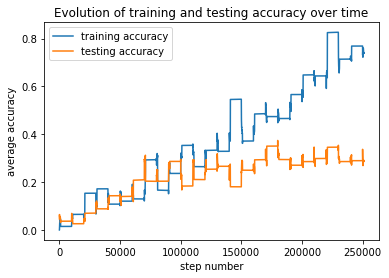

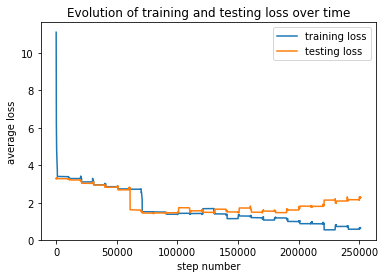

In [43]:
name = 'withMod_1_smooth'

plt.figure()

plt.plot(train_epoch, train_avg_acc, label="training accuracy")
plt.plot(train_epoch, test_avg_acc, label="testing accuracy")
plt.legend()
plt.xlabel("step number")
plt.ylabel("average accuracy")
if(is_10K):
    plt.title("Evolution of training and testing accuracy over time (10k)")
else:
    plt.title("Evolution of training and testing accuracy over time")
temp = ('results/avg_acc_%s.jpg' %name)
plt.savefig(temp)


plt.figure()

plt.plot(train_epoch, train_avg_loss, label="training loss")
plt.plot(train_epoch, test_avg_loss, label="testing loss")
plt.legend()
plt.xlabel("step number")
plt.ylabel("average loss")
if(is_10K):
    plt.title("Evolution of training and testing loss over time (10k)")
else:
    plt.title("Evolution of training and testing loss over time")
temp = ('results/avg_loss_%s.jpg' %name)
plt.savefig(temp)

In [3]:
def smoother(l, nbr=2):
    new_l = l
    for i in range(0,np.shape(l)[0]-nbr+1):
        new_l[i] = float(l[i])
        for j in range(1, nbr):
            new_l[i] = new_l[i] + float(l[i+j])
        new_l[i] = new_l[i]/nbr
    return new_l